In [1]:
import keras

import scipy.io

import scipy.signal as ss

import numpy as np
import matplotlib.pyplot as plt


import theano.tensor as T
import theano.tensor.fft as TF

import keras.backend as K


from keras import models
from keras import optimizers
from keras import regularizers
from keras import layers
from keras import utils
from keras import metrics
from keras import activations

from keras.layers import Layer, InputSpec
from keras.utils  import conv_utils


from complexnn.activations import *
from complexnn.loss        import *
from complexnn.pool        import *
from complexnn.utils       import *

from fb.conv      import *
from fb.analysis  import *
from fb.synthesis import * 
from fb.resample  import *
from fb.models    import DyadicNet, PacketNet, DummyNet
from fb.contra    import FBLMS, RLMS

from datasets.signal import *
from datasets.interf import *
from datasets.utils  import *
from datasets.fading import *


from sklearn.model_selection import train_test_split

print(keras.__version__)

%load_ext autoreload
%autoreload 2

Using Theano backend.
/usr/local/lib/python3.6/dist-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')
/usr/local/lib/python3.6/dist-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: GeForce RTX 2070 SUPER (0000:01:00.0)


2.2.5


In [2]:
class CFAR1D:
    def __init__(self, guard, train, Pfa=1E-5):
        self.fir = np.ones(shape=(2 * (guard + train) + 1, ))
        self.fir[train : train + 2 * guard + 1] = 0
        
        N = np.sum(self.fir)
        self.T = N * (np.power(Pfa, -1.0 / N) - 1)
        self.fir *= 1 / N
        
    def run(self, C):
        No = scipy.signal.oaconvolve(C, self.fir, "full")[:C.shape[0]]
        return ((C / No) > self.T) * C


class DSSS(Signal):
    @staticmethod
    def generate_msr(length):
        nbits= int(np.ceil(np.log2(length)))
        pn, _ = ss.max_len_seq(nbits=nbits, length=length)
        return 2.0 * pn - 1.0

    @staticmethod
    def generate_bits(length):
        return np.random.randint(0, 2, length)

    def __init__(self, Fs, W, Lc=2048, alpha=0.5, taps=32, Fc=0):
        super(DSSS, self).__init__(Fs, W, Fc)

        self.Tp = int(Fs / W)
        self.Lc = Lc

        self.Td = self.Lc * self.Tp
        self.Ts = self.Tp / self.Fs
        
        self.qpsk = QPSK()

        _, self.f = rrcosfilter(taps, alpha=alpha, Ts=self.Ts, Fs=self.Fs)
        self.pn = scipy.signal.resample_poly(self.generate_msr(self.Lc), self.Tp, 1)
 
    def generate_qpsk(self, N):
        length = int(np.ceil(N / self.Td))
        
        self.bits = self.generate_bits(length * 2)
        self.symbols = self.qpsk.modulate(self.bits)
        
        return np.repeat(self.symbols, self.Td)

    def generate(self, N):
        data = self.generate_qpsk(N)
        
        m = data.shape[0] // self.pn.shape[0]
        pn = self.pn
        for i in range(m):
            pn = np.hstack((pn, self.pn))
            
        return data * pn[:data.shape[0]]
    
    def detect(self, S, cfar, sigma):
        C = scipy.signal.oaconvolve(S, self.pn[::-1], mode='valid')
        Ca = np.abs(C)
        D = cfar.run(Ca)
        
        ret = 0
        for i in range(1, D.shape[0] // self.pn.shape[0]):
            ret += (np.sum(D[i * self.pn.shape[0] - sigma : 
                             i * self.pn.shape[0] + sigma]) > 0)
        return ret / (D.shape[0] // self.pn.shape[0] - 1)
    
    def demodulate(self, S, cfar, ph = 0):
        C = scipy.signal.oaconvolve(S, self.pn[::-1], mode='valid')
        Ca = np.abs(C)
        D = cfar.run(Ca)
        
        Sm = np.exp(-1j * ph) * ((D > 0) * C)[::self.Td]
        Dm = (D > 0)[::self.Td]
        Bh = np.int32(self.qpsk.demodulate(Sm))
        return Bh, Dm
    
    def calc_metrics(self, S, cfar, ph = 0):
        Bh, Dm = self.demodulate(S, cfar, ph)
        B = self.bits
        
        ret = 0
        for i in range(Bh.shape[0]):
            if Dm[i // 2] == 1:
                ret += np.abs(Bh[i] - B[i])
        
        return ret / Bh.shape[0], np.mean(Dm)
    
class PeakConstrainedRegularizer(regularizers.Regularizer):
    def __init__(self, kappa):
        self.kappa = kappa
        self.mu    = (1 / self.kappa)

    def __call__(self, h):
        l = h._keras_shape[0]
        if l == 1:
            return 0
        
        m = l // 2
        if l % 2 == 0:
             m -= 1
        
        h0 = K.sum(h[m, :, :] ** 2)
        h1 = K.sum(h[m + 1:, :, :] ** 2) + K.sum(h[0:m, :, :] ** 2)
        
        return self.mu * K.abs(h0 - l * h1)

    def get_config(self):
        return {'kappa': self.kappa, 'mu' : self.mu}    

In [10]:
B = 256
N = 1024
M = 128 * N * 2 + B

Fs = 2E6

SIRdB, SNRdB = -30, -10

dsss = DSSS(Fs=Fs, W=0.5 * Fs, Lc=N, alpha=0.01, taps=257)
St = dsss.generate(M)[:]

G = dsss.pn.shape[0]

gen = InfrGenerator([NoiseInfr], SIRdB=SIRdB, W=Fs/50, M=2 * 2048, Fs=Fs)
No  = NoiseSignal(Fs=Fs, W=Fs, Fc=0).generate(St.shape[0])[:St.shape[0]]
No *= np.std(St) / (10 ** (SNRdB / 20))

Fc = 200
Sx = (St + No) * np.exp(1j * 2 * np.pi * Fc * (np.arange(0, St.shape[0]) / Fs))

X, y, Sr = gen.dataset(Sx, G)
X, y = X[:G * B // 2], y[:G * B // 2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0625, shuffle=True)

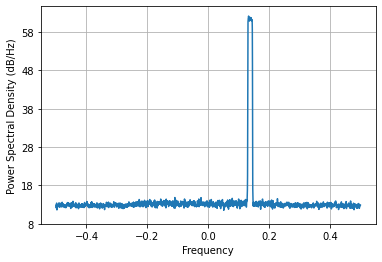

In [11]:
plt.psd(Sr, NFFT=G, Fs=1)
plt.show()

Train on 245760 samples, validate on 16384 samples
Epoch 1/1
245760/245760 [==============================] - 12s 49us/step - loss: 61.5081 - WelchKL: 0.7213 - val_loss: 0.6319 - val_WelchKL: 0.2124


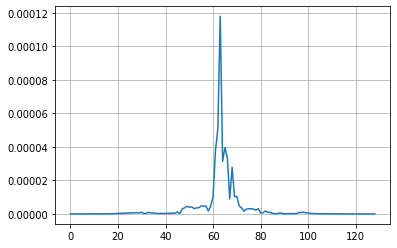

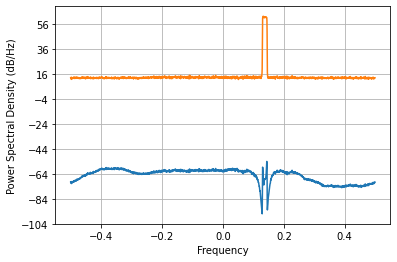

In [13]:
window = 'blackmanharris'

snapshot = WelchKL.compute_snapshot(St, G, window=window)
loss     = WelchKL(snapshot=snapshot, window=window)

reg = PeakConstrainedRegularizer(kappa=0.01)

L = 6
taps = [(2**l + 1) for l in range(1, L + 1)]

model = DummyNet(N=G, B=B, comp='simple', taps=taps, regularizer=reg, use_factor=False, L=L)

model.set_activation(Linear)
model.set_analysis(ConvSimple)
model.set_synthesis(WeightedSum)
        
model.build()
model.compile(optimizers.Nadam(lr=0.0005), loss)

_ = model.train(X_train, y_train, X_test, y_test, epochs=1, batch_size=B)

ir = model.IR(taps=2**(L+1)+1)

plt.plot(np.abs(ir))
plt.grid(True)
plt.show()

Sth = scipy.signal.convolve(Sr, ir, mode="full")
plt.psd(Sth, NFFT=2 * N, Fs=1)
plt.psd(Sr, NFFT=2 * N, Fs=1)
plt.show()

Ca = np.abs(scipy.signal.oaconvolve(Sth, dsss.pn[::-1], mode="valid"))